## single photon imaging
simulate single photon interference imaged on an EMCCD

In [1]:
from numpy import *
from numpy.random import random as rand
from scipy.special import gamma
from scipy.sparse import bsr_array
from matplotlib import pyplot as plt

In [2]:
def sample(func,size,domain,fmax=1,integer=False,showplot=False):
        """ 
        Sample random speeds with a Maxwell-Boltzmann dist. 
        Args:
            'size': sample size
            'domain': [v1,v2] the restricted domain of the pdf; e.g.
                a Guassian goes to ~ zero well before inf so we can
                let the domain be a finite region
            'fmax': the maximum of the probability distribution. assumed one unless otherwise stated
            'integer': True if sample should only contain integers, e.g. for a Poisson dist.
        Returns:
            an array of length size for size > 1, else a scalar
        """
        n = size
        v1,v2 = domain

        y_dist = empty(n)
        f_dist = empty(n) 
        v_dist = empty(n) # this is the distribution we want
        j = 0 # dist index
        
        if integer:
            vsamp = lambda v1,v2: int((v2-v1)*rand()+0.5)
        else:
            vsamp = lambda v1,v2:  (v2-v1)*rand()
        
        while j < n:
            v = vsamp(v1,v2) # rand val on domain of f(x)
            f = func(v)
            y = rand()*fmax # rand val on range of f(x)
            if y <= f:
                y_dist[j]=y
                f_dist[j]=f
                v_dist[j]=v # x vals with approximate gaussian pdf
                j+=1

        # plot distribution as a check:
        if showplot is not False:
            plt.scatter(v_dist,y_dist,c='red',s=10)
#             plt.scatter(v_dist,f_dist,c='blue',s=10)
            vpts = linspace(v1,v2,500)
            fpts = array([func(v) for v in vpts])
            plt.plot(vpts,fpts,color='blue')
            plt.show()

        if n > 1:
            return v_dist
        else:
            return v_dist[0]

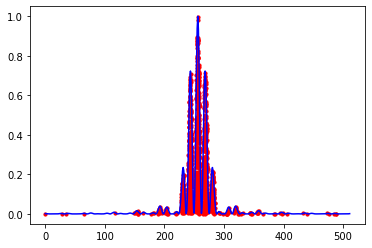

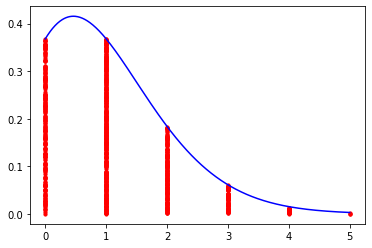

In [3]:
psi = lambda x: (sinc(2*pi*((x-256)/0.5)/512)*cos(2*pi*((x-256)/0.05)/512))**2
samp = sample(psi,1000,[0,511],showplot=True)

n=1
poisson = lambda x: exp(-n)*n**x/gamma(x+1)
samp = sample(poisson,1000,[0,5],integer=True,showplot=True)

In [6]:
n=1 # mean photons per frame
shots=1000
QE = 0.9
tau = 1e-5 # exposure
sr = 1*tau # e- per exposure
d = 0.01 # dark electrons/s, air cooling to -65 C
sd = sqrt(tau*d) # dark noise
ss = sqrt(QE*n) # photon shot noise
scic = 0.01 # clock induced charge
print("dark noise:", sd)
print("photon shot noise:", ss)
print("clock noise:", scic)
s = sqrt(sr**2+sd**2+ss**2+scic**2) # total RMS noise
print("SNR (e- per pixel per readout):",QE*n/s)

ymax=1 # the number of pixel rows in y to use
xmax=511 # same but for x

def click():
    return 1 if rand() < QE*n else 0

# the coordinates sampled from the photon wavefunction in the image plane
xvals = floor(sample(psi,shots,[0,511])+0.5)
yvals = ymax*rand(shots)

signal = (array([bsr_array(([click()],([yvals[i]],[xvals[i]])),(ymax, xmax), dtype=int8) 
                 for i in range(shots)]).sum()).toarray()

# this model for noise is incorrect. i will not have shot noise ~ sqrt(n) per pixel, but over the whole sensor.
# i.e. if I have 1 photon per frame, I have 1/(xmax*ymax) chance of getting a click anywhere on the array

noise = array([[sample(poisson,xmax,[0,6*n],integer=True) for j in range(ymax)] for k in range(shots)]).sum(axis=0)
bg = array([[sample(poisson,xmax,[0,6*n],integer=True) for j in range(ymax)] for k in range(shots)]).mean(axis=0)

dark noise: 0.00031622776601683794
photon shot noise: 0.9486832980505138
clock noise: 0.01
SNR (e- per pixel per readout): 0.9486305450659538


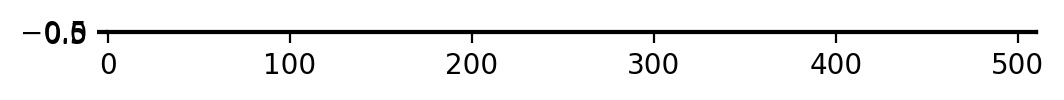

In [108]:
fig,ax = plt.subplots(dpi=200)
ax.imshow(noise+signal)

In [ ]:
noise

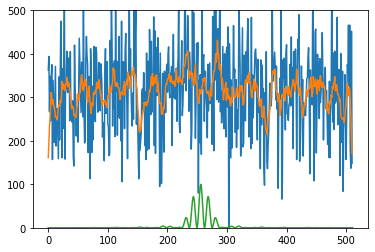

In [109]:
data = (noise+signal)[0,:]
data /= bg
plt.plot(data)
# kernel_size=10
# kernel = np.ones(kernel_size) / kernel_size
# data_conv = np.convolve(data, kernel, mode='same')
# plt.plot(data_conv)
plt.plot()
plt.ylim((0,500))
plt.plot(100*psi(array(range(512))))

In [65]:
frames = array([[sample(poisson,xmax,[0,6*n],integer=True) for j in range(ymax)] for k in range(shots)])

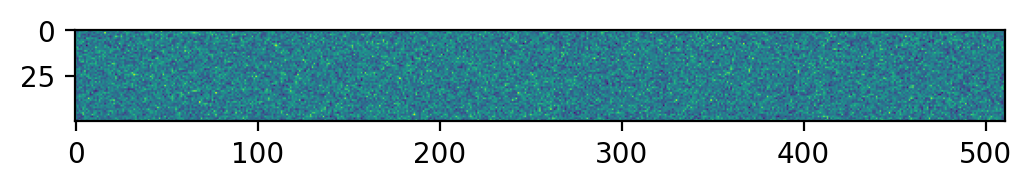

In [67]:
noise = frames.sum(axis=0)
fig,ax = plt.subplots(dpi=200)
ax.imshow(noise)

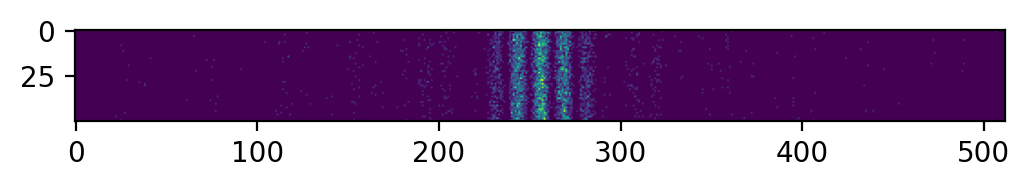

In [26]:
fig,ax = plt.subplots(dpi=200)
ax.imshow(signal)

In [12]:
QE=0.5
def click():
    return 1 if rand() < QE else 0

[click() for i in range(10)]

[1, 1, 1, 0, 0, 0, 0, 0, 1, 1]

In [6]:
from scipy.sparse import bsr_array
bsr_array(([1],([1],[1])),(3, 4), dtype=int8).toarray()

array([[0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0]], dtype=int8)

In [30]:
!python --version

Python 3.9.6


In [11]:
(array([bsr_array(([i],([1],[1])),(3, 4), dtype=int8) for i in range(4)]).sum()).toarray()

array([[0, 0, 0, 0],
       [0, 6, 0, 0],
       [0, 0, 0, 0]], dtype=int8)